In [55]:
# load libs
library(tidyverse)
library(patchwork)
library(GenomicAlignments)
library(rstatix)

# glob opt
options(
    warn=-1,
    repr.plot.width = 5,
    repr.plot.height = 3,
    repr.plot.res = 300
)

### QC data

In [56]:
# qc stats
qc_files <- list.files(
  path = "data/qc",
  pattern = ".*tab.gz",
  recursive = TRUE,
  full.names = TRUE
)
names(qc_files) <- str_replace(
  qc_files, "(.*qc/)(.*)([.]tab.*)", "\\2"
)

# read qc data
qc_all_tb <- lapply(qc_files, function(x){
    suppressMessages(
        read_tsv(x, col_names = FALSE)
    )}
    ) %>%
    bind_rows(
        .id = "library"
    ) %>% 
    mutate(
        lib_type = case_when(
            grepl("hp", library) ~ "high-performance",
            TRUE ~ "standard"
        ),
        X2 = as_datetime(gsub("st:Z:", "", X2))
    ) %>% 
    group_by(library) %>% 
    mutate(
        experiment_time = round(difftime(X2, min(X2), units="mins")),
        lib_type = factor(lib_type, levels = c("high-performance", "standard"))
    ) %>% 
    select(-X2:-X4) %>%
    dplyr::rename(
        seqid = "X1"
    ) %>% 
    ungroup() 

# passed reads
qc_passed_tb <- qc_all_tb %>% 
    filter(X6 >= 9)


### Pore activity data

In [57]:
# pore stats
pa_files <- list.files(
  path = "data/reports",
  pattern = "pore_activity.*",
  recursive = TRUE,
  full.names = TRUE
)
names(pa_files) <- str_replace(
  pa_files, "(.*reports/)(.*)(/p.*)", "\\2"
)

# read data
pa_tb <- lapply(pa_files, function(x){
    suppressMessages(
        read_csv(x, col_names = TRUE)
    )}
  ) %>% 
  bind_rows(
    .id = "library"
  ) %>% 
  mutate(
    olength = str_extract(library, "^[0-9]{2}"),
    lib_type = case_when(
      grepl("hp", library) ~ "high-performance",
      TRUE ~ "standard"
    ),
    lib_type = factor(
      lib_type, levels = c("high-performance", "standard")
    )
  ) %>% 
  filter(
    `Experiment Time (minutes)` < 85
  )


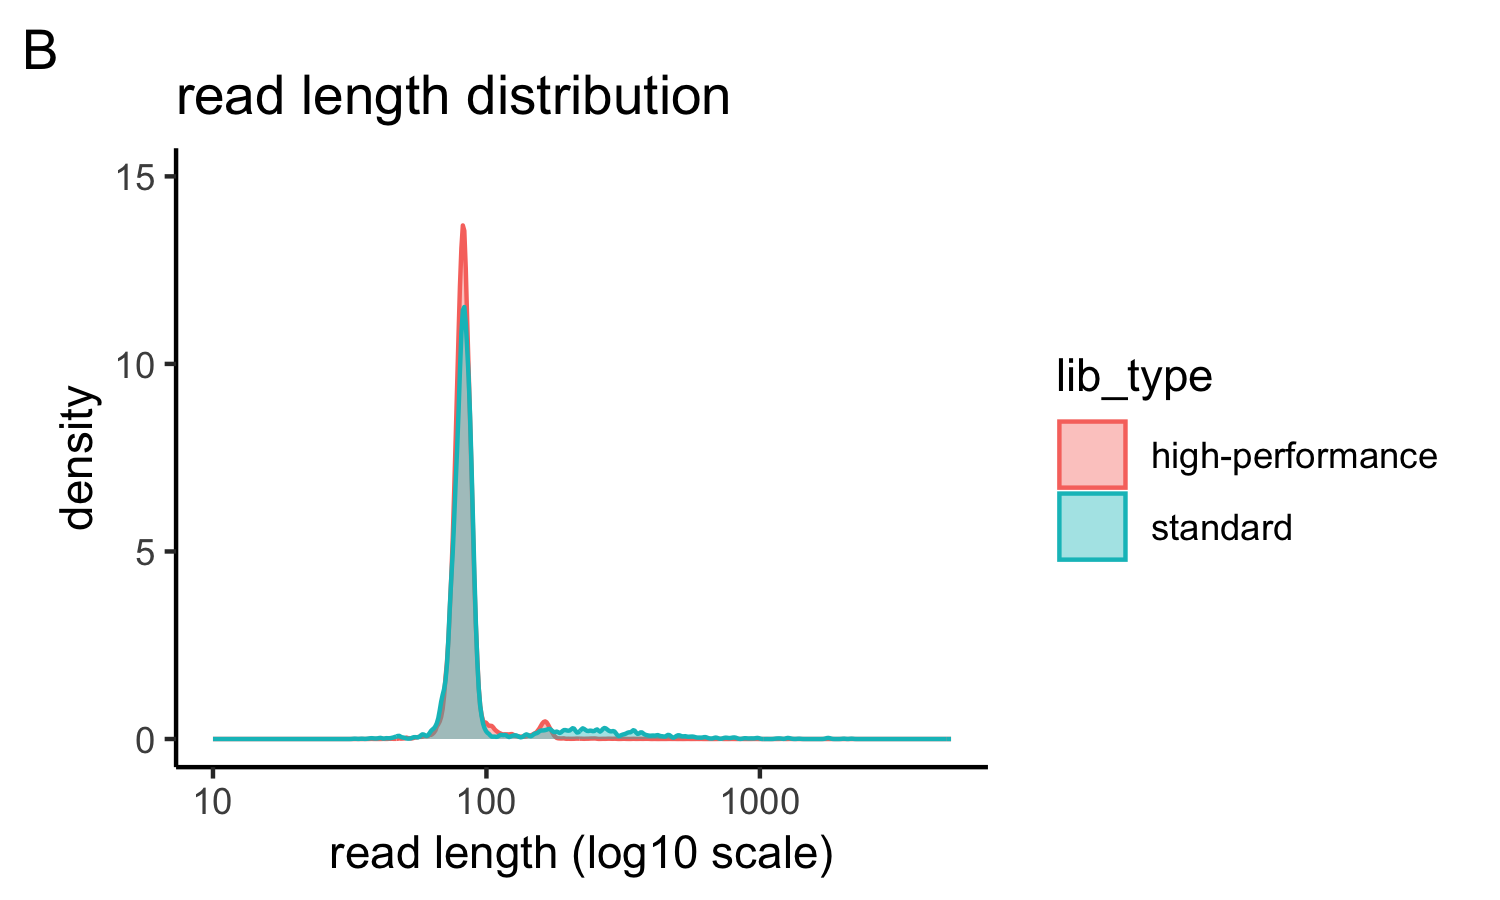

In [58]:
###
### Figure 1B
###

f1b <- qc_passed_tb %>% 
  ggplot(aes(X5, color = lib_type, fill = lib_type)) +
  geom_density(alpha=0.4) +
  scale_x_log10(limits = c(10, 5000)) +
  theme_classic() +
  lims(y = c(0, 15)) +
  labs(
    tag = "B",
    title = "read length distribution",
    x = "read length (log10 scale)"
  )

f1b


`summarise()` has grouped output by 'lib_type'. You can override using the `.groups` argument.
Don't know how to automatically pick scale for object of type <difftime>. Defaulting to continuous.


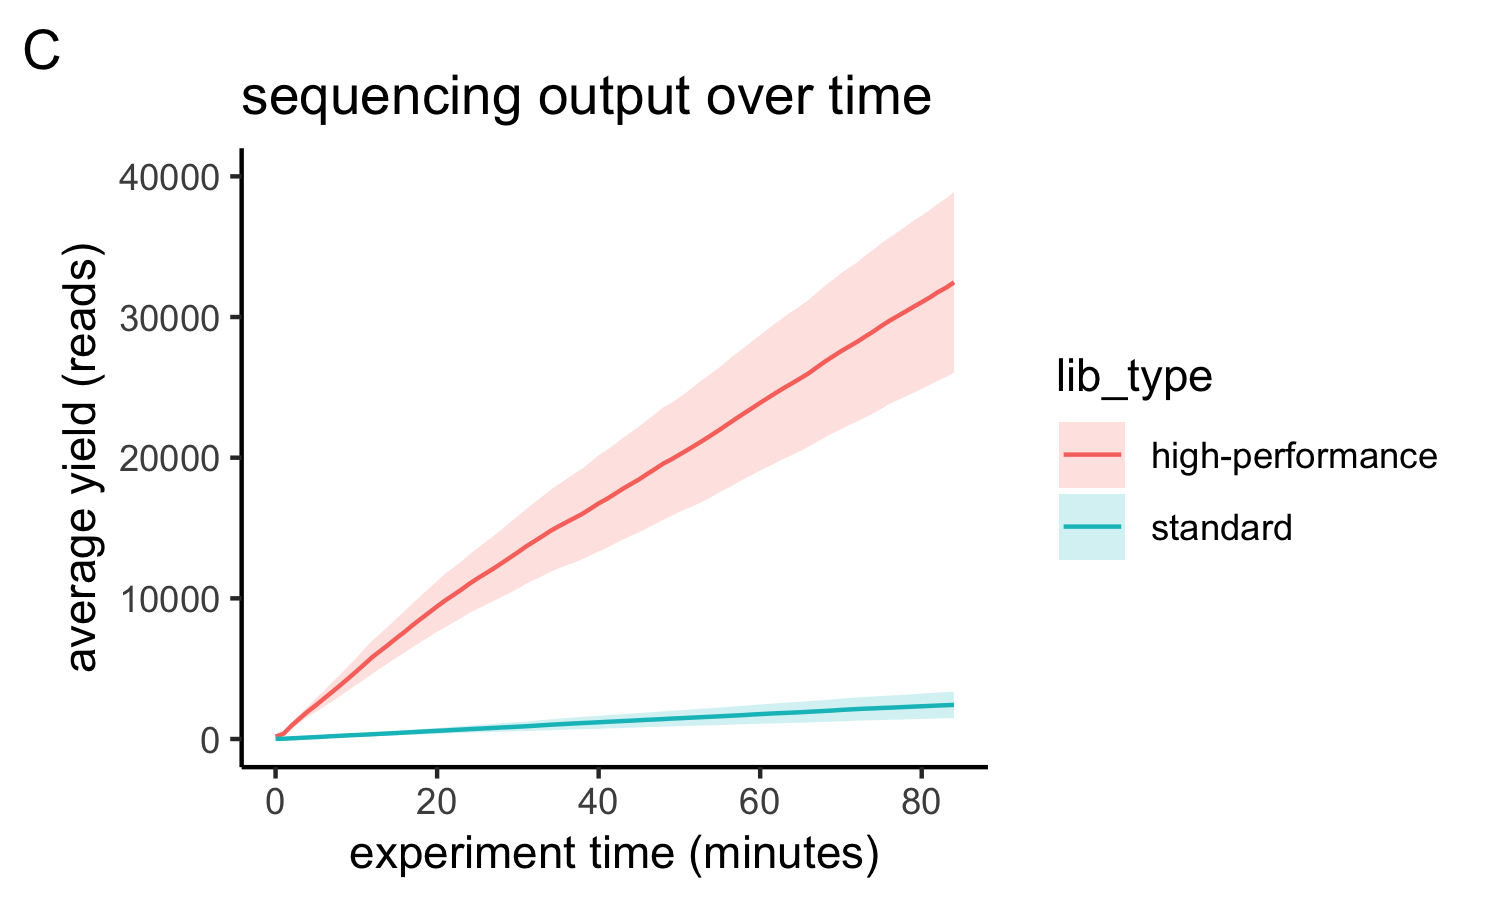

In [59]:
###
### Figure 1C
###

f1c_tb <- qc_all_tb %>% 
  group_by(library, lib_type, experiment_time) %>% 
  tally() %>% 
  mutate(Reads = cumsum(n)) %>% 
  group_by(lib_type, experiment_time) %>% 
  summarise(
    Reads_mean = mean(Reads),
    Reads_se = sd(Reads)/sqrt(length((Reads)))
  ) %>% 
  ungroup() %>% 
  filter(experiment_time < 85) %>% 
  dplyr::rename(
      "experiment time (minutes)" = "experiment_time"
  )

f1c <- f1c_tb %>% 
  ggplot(aes(
    `experiment time (minutes)`,
    Reads_mean,
    color = lib_type,
    group = lib_type
  )) +
  geom_line() +
  geom_ribbon(
    aes(ymin = Reads_mean - Reads_se, ymax = Reads_mean + Reads_se, fill = lib_type),
    color = NA, alpha = 0.2
  ) +
  theme_classic() +
  lims(y=c(0, 4e4)) +
  labs(
    tag = "C",
    title = "sequencing output over time", 
    x = "experiment time (minutes)",
    y = "average yield (reads)"
  )

f1c


,.y.,group1,group2,n1,n2,statistic,df,p
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
t,n,high-performance,standard,3,4,4.160861,2.063288,0.0252


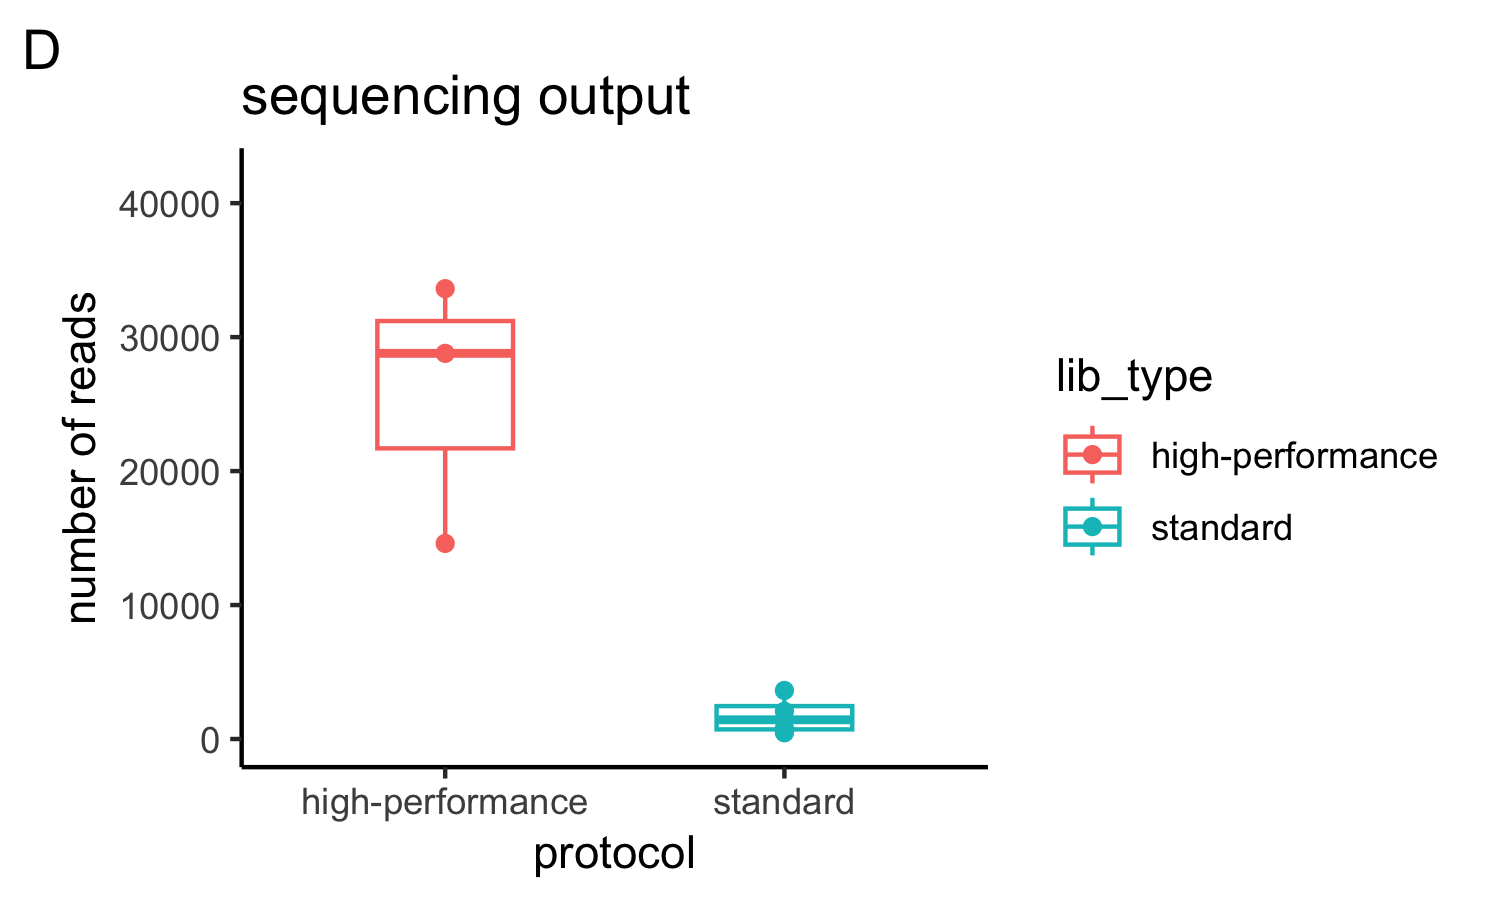

In [60]:
###
### Figure 1D
###

f1d_tb <- qc_passed_tb %>% 
  group_by(
    library, lib_type
  ) %>% 
  tally() %>% 
  ungroup()

# perform  t-test
ttest_res <- f1d_tb %>% 
  t_test(
    n ~ lib_type,
    comparisons = list(
      c("high-performance", "standard")
    ),
    alternative = "greater"
  )
ttest_res

f1d <- f1d_tb %>% ggplot(
  aes(lib_type, n, color = lib_type)
  ) +
  geom_boxplot(width = 0.4) +
  geom_jitter(position = position_dodge(width = 0.4)) +
  theme_classic() +
  scale_y_continuous(
      limits = c(0, 4.2e4)
  ) +
  labs(
    tag = "D",
    title = "sequencing output", 
    x = "protocol",
    y = "number of reads"
  )

f1d


`summarise()` has grouped output by 'lib_type'. You can override using the `.groups` argument.


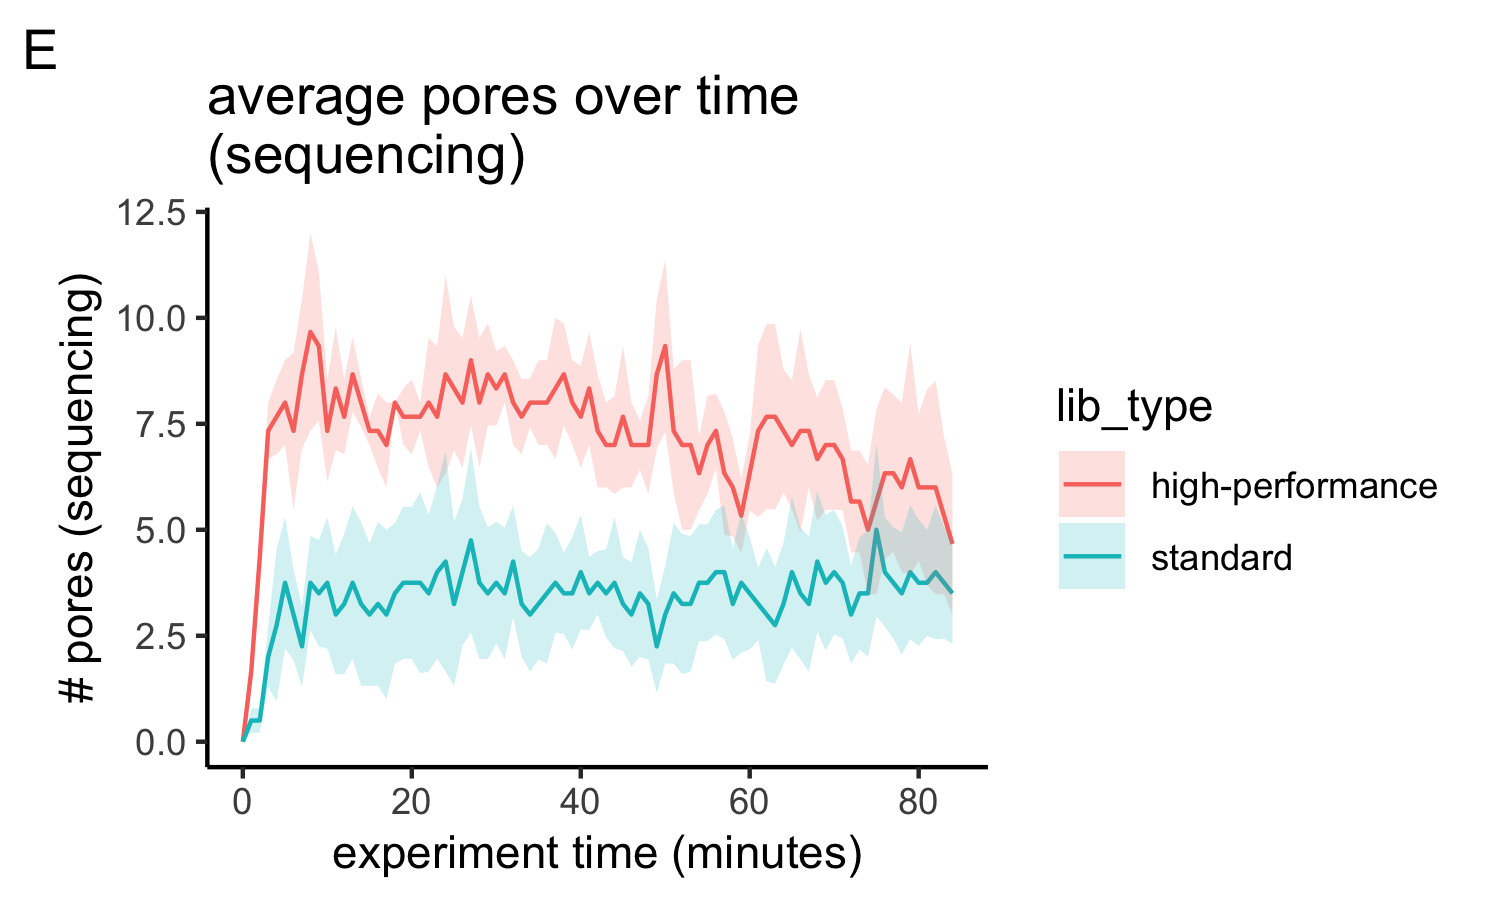

In [61]:
###
### Figure 1E
###

f1e_tb <- pa_tb %>% 
  filter(
    `Channel State` == "strand"
  ) %>% 
  mutate(
    n_pores = case_when(
      `State Time (samples)` != 0 ~ round(`State Time (samples)`/(5e3*60)),
      TRUE ~ 0
    )
  ) %>% 
  group_by(
    lib_type, `Experiment Time (minutes)`
  ) %>% 
  summarise(
    pore_mean = mean(n_pores),
    pore_se = sd(n_pores)/sqrt(length((n_pores)))
  ) %>% 
  ungroup()

f1e <- f1e_tb %>% ggplot(
    aes(`Experiment Time (minutes)`, pore_mean, color = lib_type, group = lib_type)
  ) +
  geom_line() +
  geom_ribbon(
    aes(ymin = pore_mean - pore_se, ymax = pore_mean + pore_se, fill = lib_type),
    color = NA, alpha = 0.2
  ) +
  theme_classic() +
  labs(
    tag = "E",
    title = "average pores over time\n(sequencing)", 
    x = "experiment time (minutes)",
    y = "# pores (sequencing)"
  )
f1e

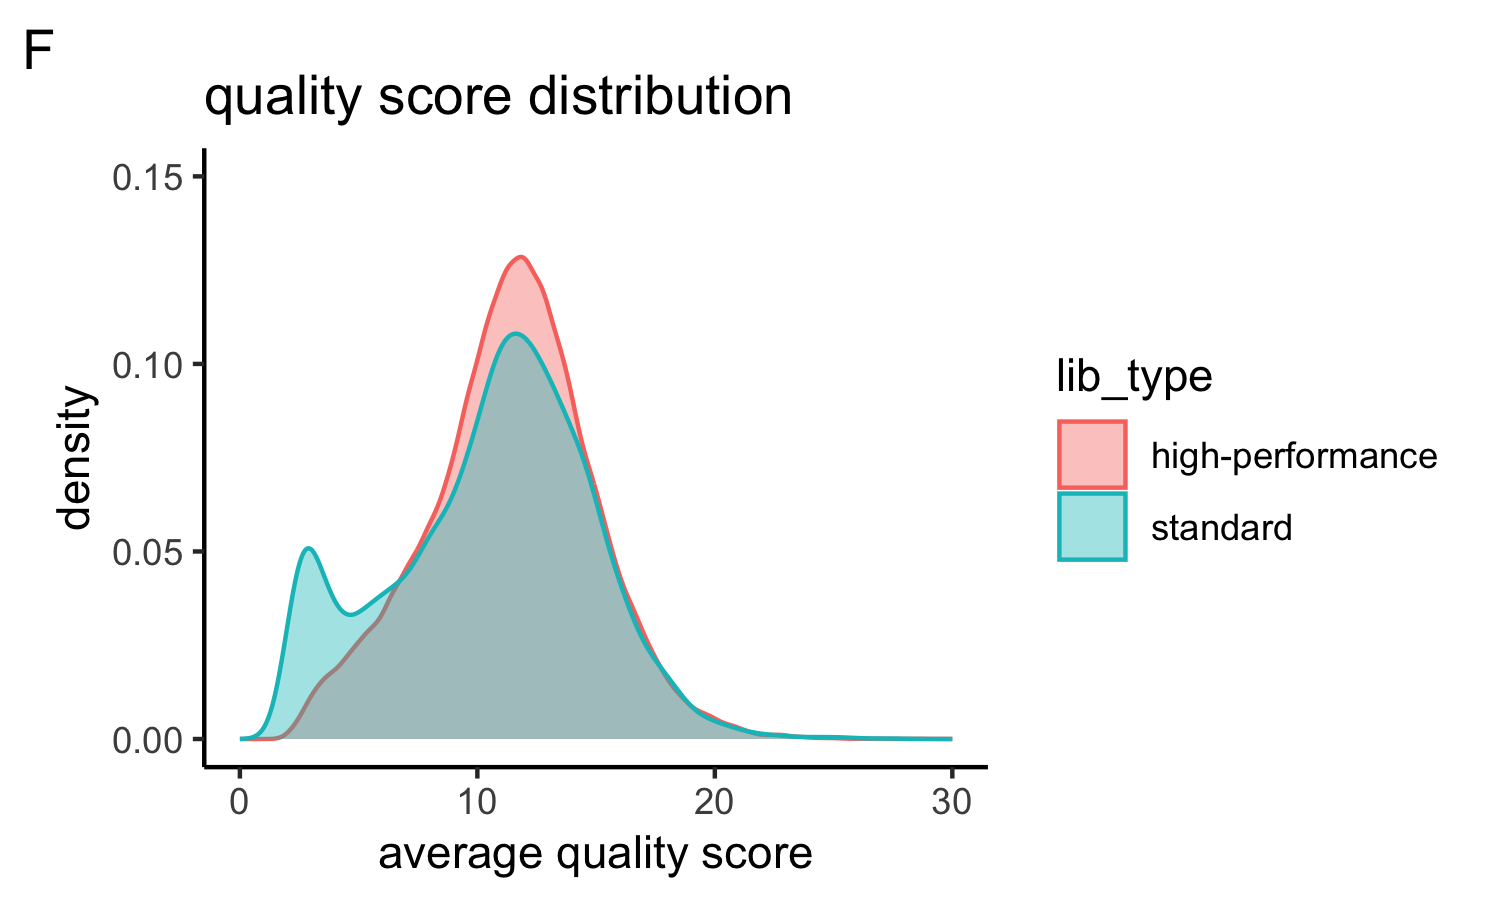

In [62]:
###
### Figure 1F
###

f1f <- qc_all_tb %>% 
  ggplot(aes(X6, color = lib_type, fill = lib_type)) +
  geom_density(alpha=0.4) +
  theme_classic() +
  lims(x = c(0,30), y = c(0, 0.15)) +
  labs(
    tag = "F",
    title = "quality score distribution",
    x = "average quality score"
  )

f1f


`summarise()` has grouped output by 'lib_type'. You can override using the `.groups` argument.
Don't know how to automatically pick scale for object of type <difftime>. Defaulting to continuous.


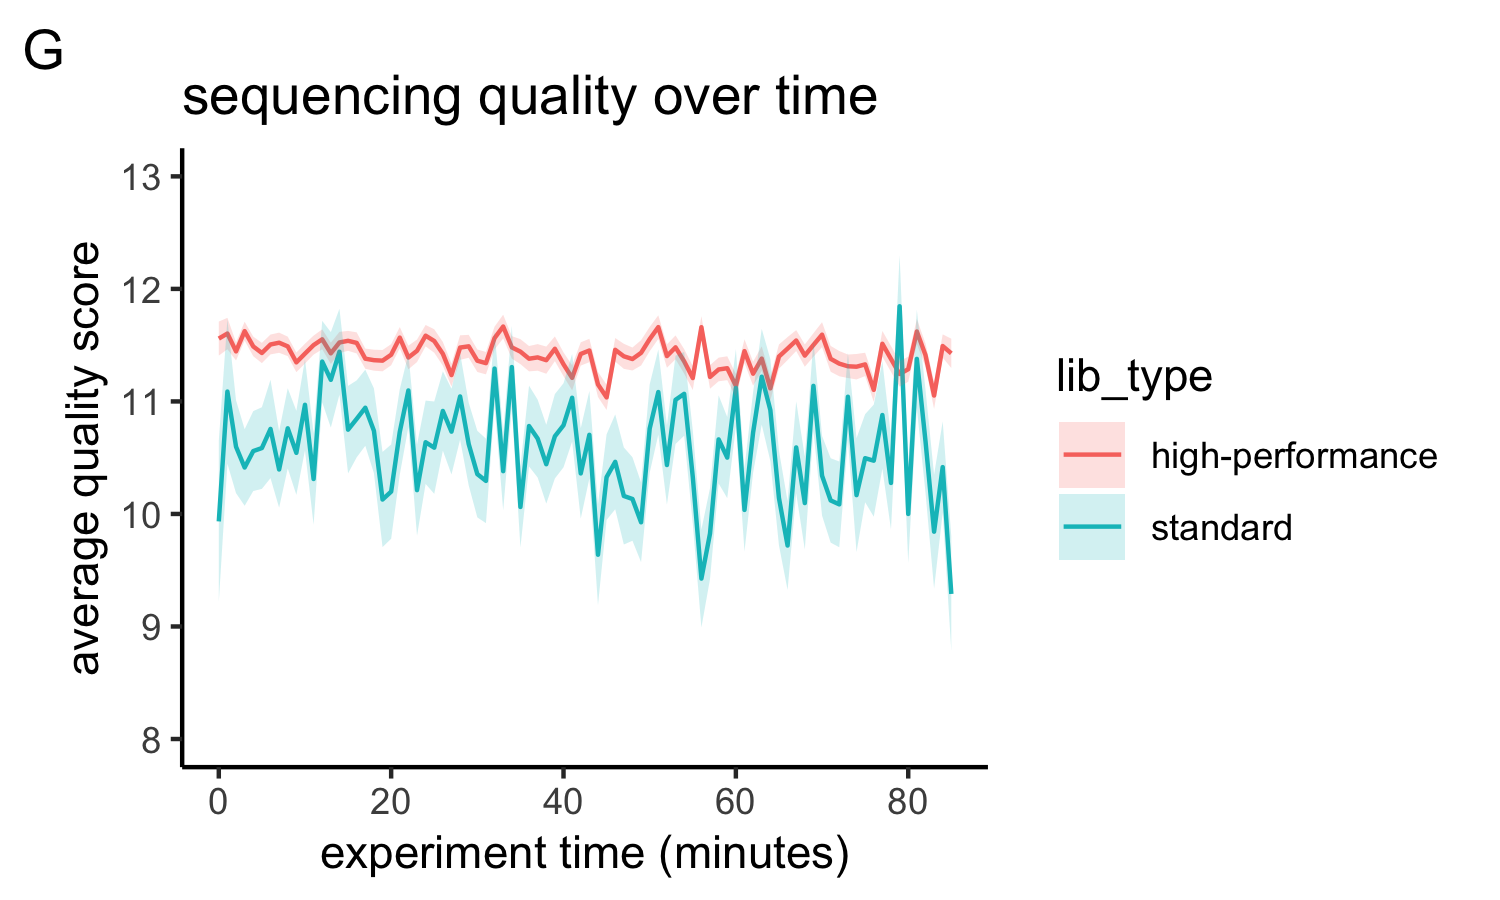

In [63]:
###
### Figure G
### 

f1g_tb <- qc_all_tb %>% 
  group_by(
    lib_type, experiment_time
  ) %>% 
  summarise(
    qscore_mean = mean(X6),
    qscore_se = sd(X6)/sqrt(length((X6)))
  ) %>% 
  ungroup() %>% 
  filter(
    experiment_time < 86
  )

f1g <- f1g_tb %>% ggplot(
    aes(experiment_time, qscore_mean, color = lib_type, group = lib_type)
  ) +
  geom_line() +
  geom_ribbon(
    aes(ymin = qscore_mean - qscore_se, ymax = qscore_mean + qscore_se, fill = lib_type),
    color = NA, alpha = 0.2
  ) +
  theme_classic() +
  lims(y=c(8,13)) +
  labs(
    tag = "G",
    title = "sequencing quality over time", 
    x = "experiment time (minutes)",
    y = "average quality score"
  )

f1g


### alignment stats

In [65]:
# get bam files
bam_files <- list.files(
    path = "data/bam",
    pattern = ".bam$",
    recursive = TRUE,
    full.names = TRUE
    )

names(bam_files) <- str_replace(
  bam_files, "(.*bam/)(.*)([.]bam$)", "\\2"
)

# read files
param <- ScanBamParam(
  tag=c("NM"),
  what=c("isize", "mapq")
)

bam_tb <- lapply(bam_files, function(x){
  readGAlignments(
    x, use.names = TRUE,
    param = param
  ) %>% 
    as_tibble(
      rownames = "seqid"
    )}
  ) %>% 
  bind_rows(
    .id ="library"
  ) %>% 
  mutate(
    ref_width = as.numeric(
      str_remove(seqnames, "frag_")
    ),
    lib_type = case_when(
      grepl("hp", library) ~ "high-performance", TRUE ~ "standard"
    ),
    lib_type = factor(
      lib_type, levels = c("high-performance", "standard")
    ),
    coverage = width/ref_width*100L
  )

bam_tb_time <- bam_tb %>% 
  left_join(., qc_all_tb,)

map_tb <- bam_tb %>% 
  filter(
    NM < 3 & width > 36
  ) %>%
  group_by(library) %>%
  tally(name = "n_mapped") %>% 
  ungroup() %>% 
  left_join(
    ., qc_passed_tb %>%
      group_by(library, lib_type) %>% 
      tally(name = "n_reads") %>%
      ungroup(),
    by = c( "library")
  ) %>% 
  mutate(
    nm_by_n_reads = n_mapped/n_reads,
    lib_type_short = case_when(
      lib_type == "high-performance" ~ "hp",
      TRUE ~ "st"
    )
  )


Joining with `by = join_by(library, seqid, lib_type)`


library,n_mapped,lib_type,n_reads,nm_by_n_reads,lib_type_short
<chr>,<int>,<fct>,<int>,<dbl>,<chr>
40bp_hp_1,21321,high-performance,33616,0.6342515,hp
40bp_hp_2,19442,high-performance,28788,0.6753508,hp
40bp_hp_3,8198,high-performance,14602,0.5614299,hp
40bp_st_1,1880,standard,3625,0.5186207,st
40bp_st_2,263,standard,800,0.3287500,st
40bp_st_3,1111,standard,2067,0.5374940,st
40bp_st_4,241,standard,466,0.5171674,st


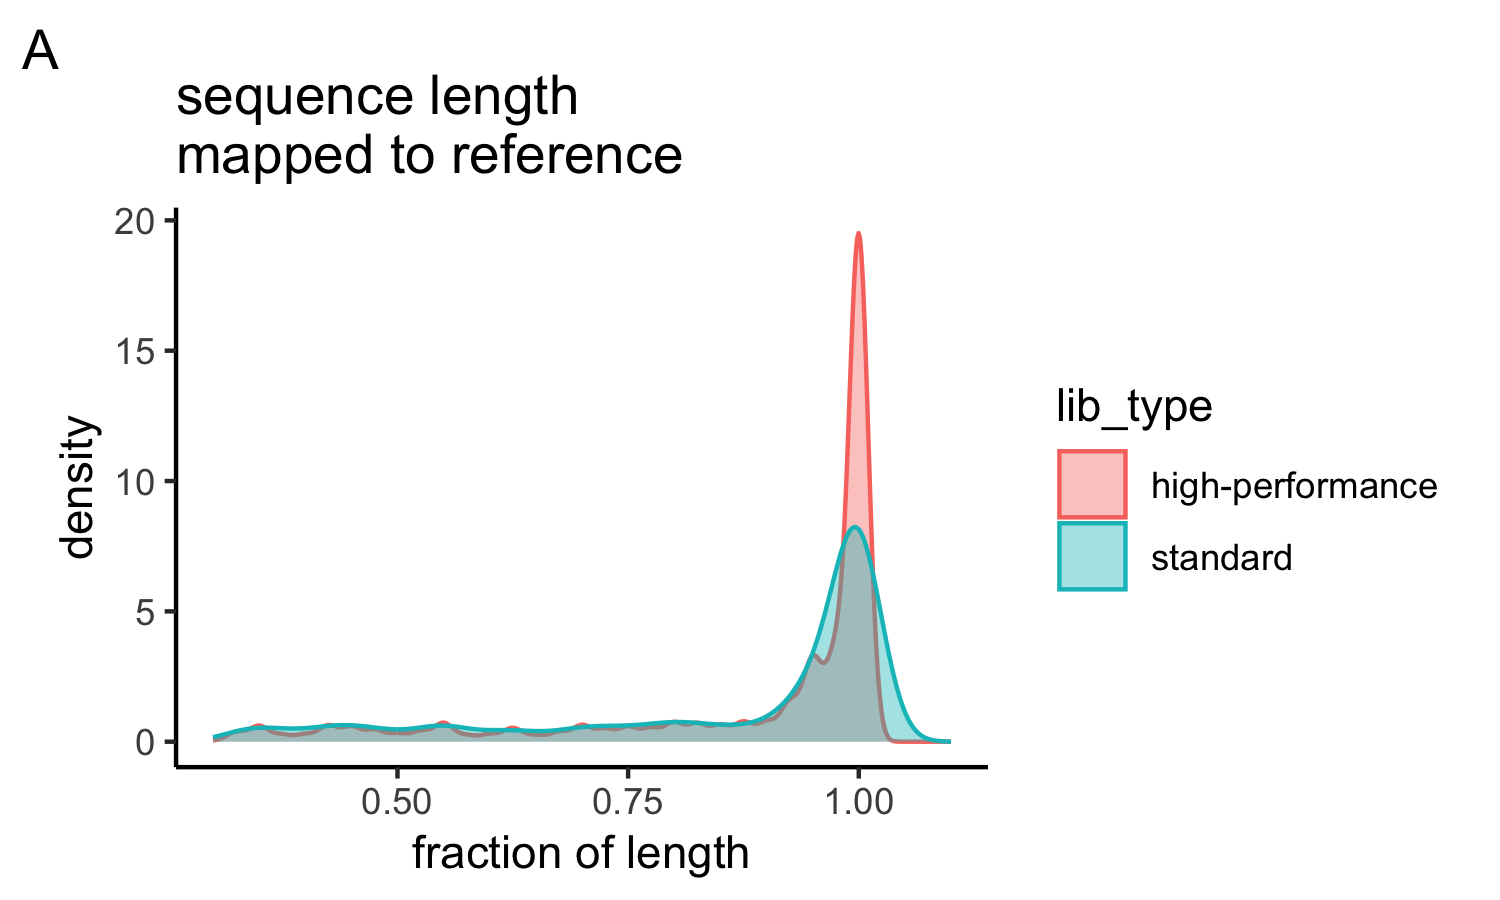

In [69]:
###
### Figure 2A
###

f2a <- bam_tb %>% 
  mutate(
    lfrac = width/ref_width
  ) %>% 
  group_by(seqid) %>% 
  top_n(1, width) %>% 
  ungroup() %>% 
  ggplot() + 
  geom_density(
    aes(x = lfrac, fill = lib_type, color = lib_type), adjust = 1, alpha = 0.4
  ) +
  theme_classic() +
  labs(
    title = "sequence length\nmapped to reference", 
    tag = "A",
    x = "fraction of length", 
    y = "density"
  ) +
  theme_classic() +
  expand_limits(x = 1.1)

f2a


,.y.,group1,group2,n1,n2,statistic,df,p
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
t,n_mapped,high-performance,standard,3,4,3.752885,2.036633,0.0312


No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


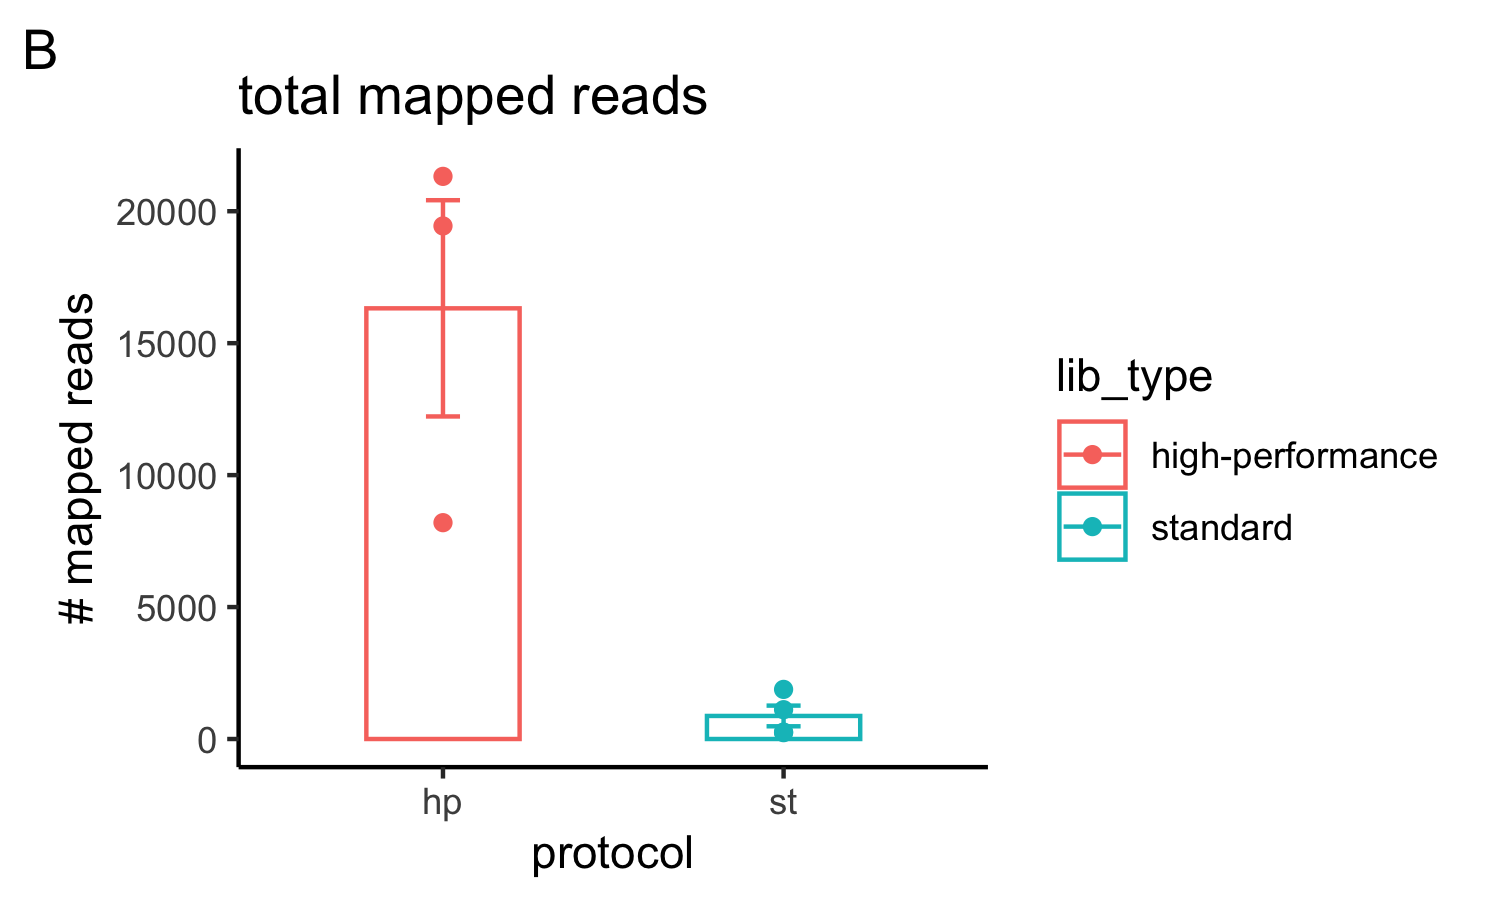

In [74]:
###
### Figure 2B
###

# perform  t-test
ttest_res <- map_tb %>% 
  t_test(
    n_mapped ~ lib_type,
    comparisons = list(
      c("hihg-performance", "standard")
    ),
    alternative = "greater"
  )
ttest_res

f2b <- map_tb %>% ggplot(
    aes(lib_type_short, n_mapped, color = lib_type)
  ) +
  geom_bar(
    stat = "summary", position = position_dodge(width = 0.45),
    width = 0.45, fill = NA
  ) +
  geom_errorbar(stat = "summary", position = position_dodge(width = 0.45), width = 0.1) +
  geom_jitter(position = position_dodge(width = 0.45)) +
  theme_classic() +
  labs(
    tag = "B",
    title = "total mapped reads", 
    x = "protocol",
    y = "# mapped reads"
  )

f2b


,.y.,group1,group2,n1,n2,statistic,df,p
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
t,nm_by_n_reads,high-performance,standard,3,4,2.495984,4.853306,0.0281


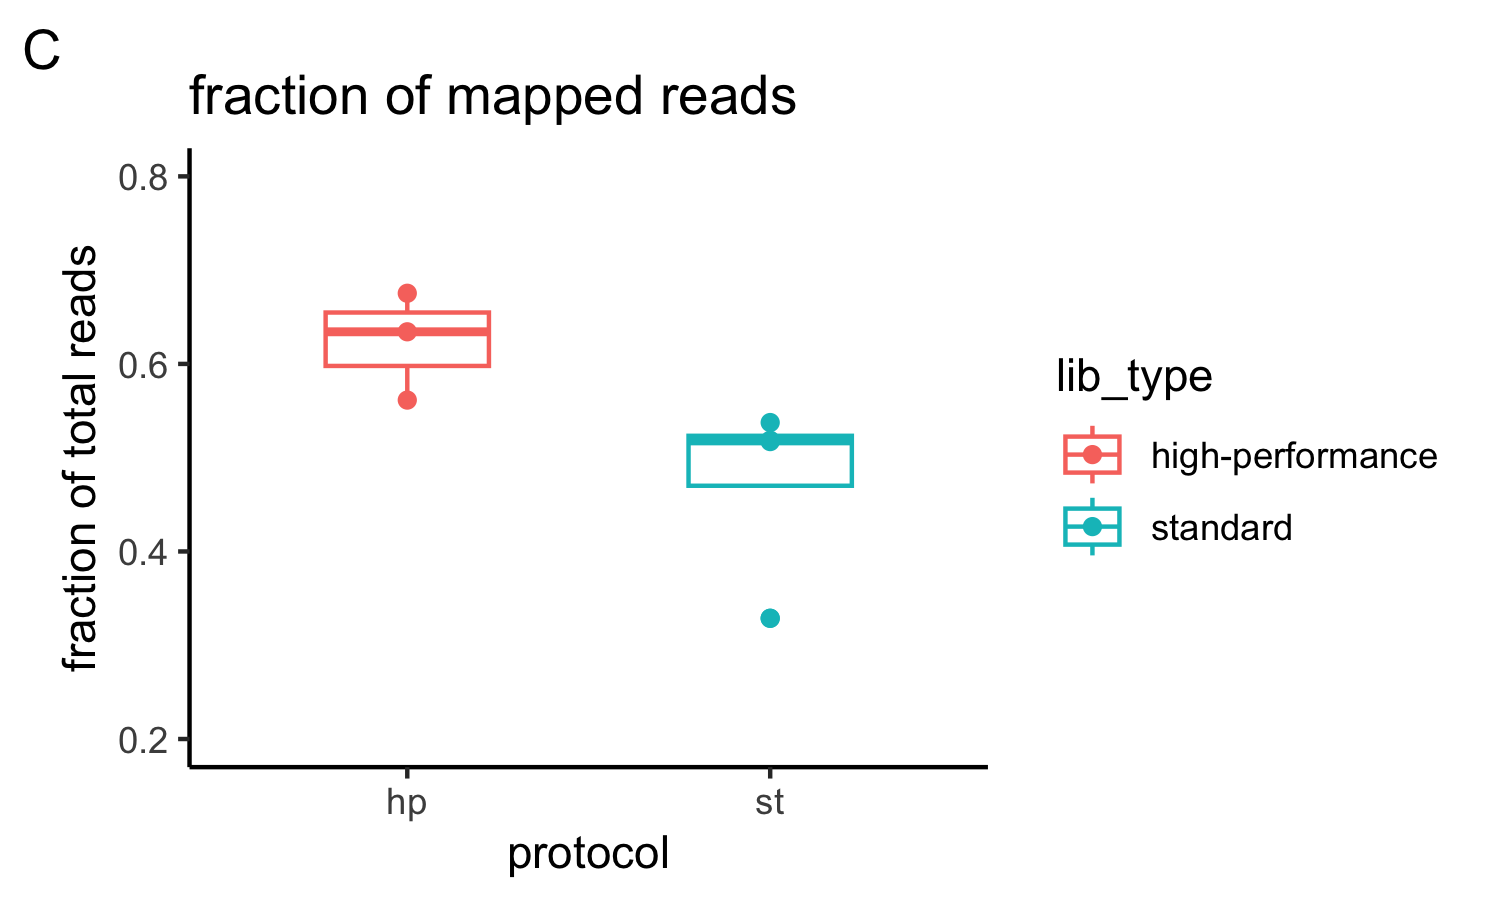

In [78]:
###
### Figure 2C
###

# perform  t-test
ttest_res <- map_tb %>%
  t_test(
    nm_by_n_reads ~ lib_type,
    comparisons = list(
      c("hihg-performance", "standard")
    ),
    alternative = "greater"
  )
ttest_res

f2c <- map_tb %>% ggplot(
  aes(lib_type_short, nm_by_n_reads, color = lib_type)
  ) +
  geom_boxplot(width = 0.45) +
  geom_jitter(position = position_dodge(width = 0.45)) +
  theme_classic() +
  ylim(c(0.2,0.8)) +
  labs(
    tag = "C",
    title = "fraction of mapped reads", 
    x = "protocol",
    y = "fraction of total reads"
  )

f2c


`summarise()` has grouped output by 'lib_type'. You can override using the `.groups` argument.
Don't know how to automatically pick scale for object of type <difftime>. Defaulting to continuous.


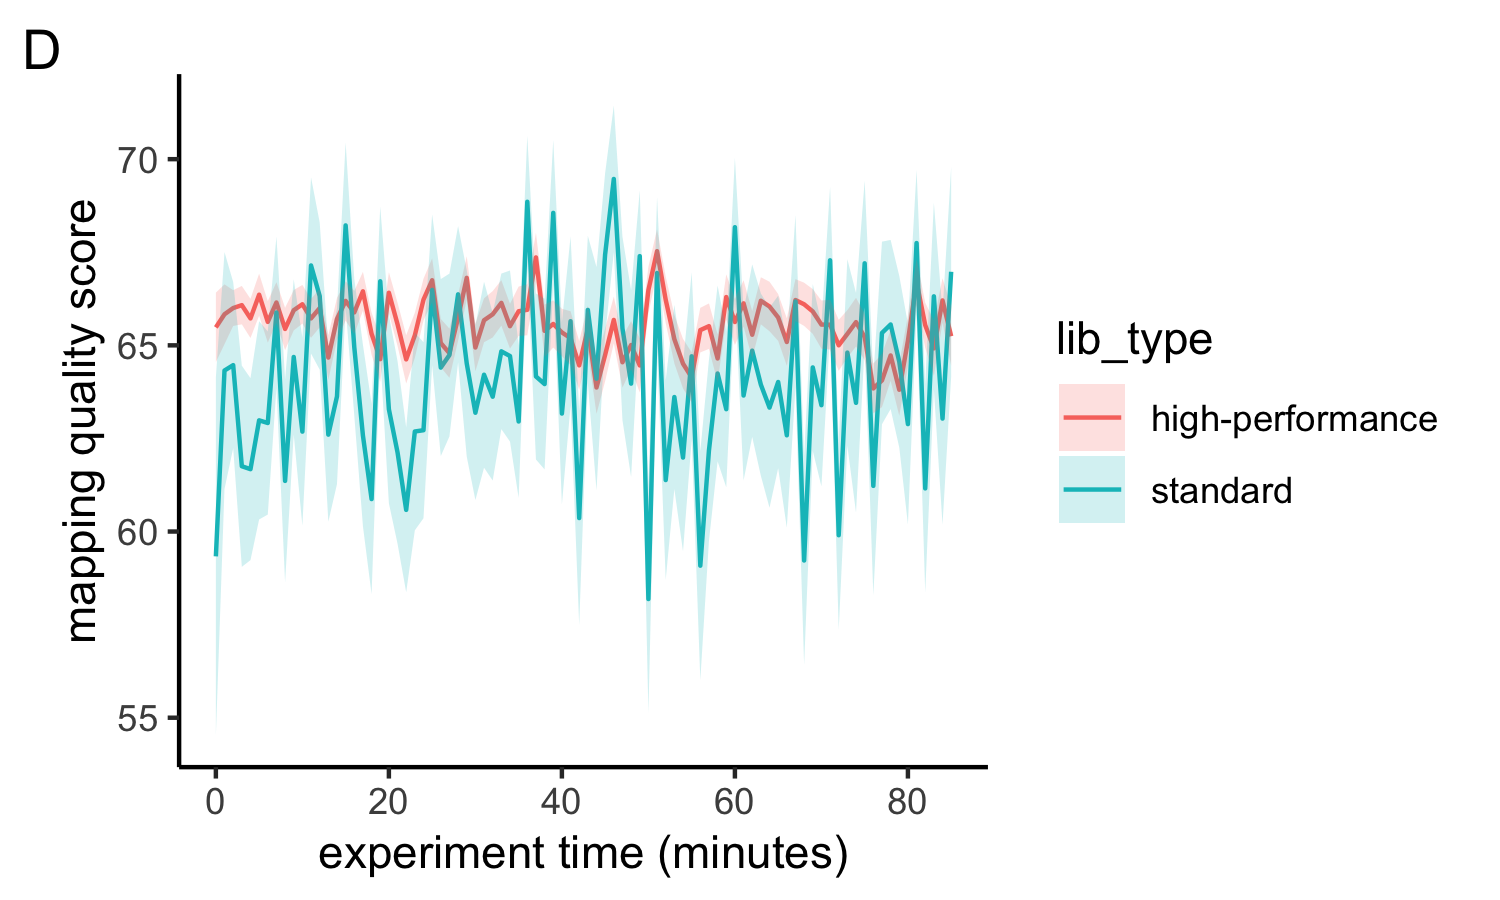

In [79]:
###
### Figure 2D
###

f2d_tb <- bam_tb_time %>% 
  group_by(
    lib_type, experiment_time
  ) %>% 
  summarise(
    mapq_mean = mean(mapq),
    mapq_se = sd(mapq)/sqrt(length((mapq)))
  ) %>% 
  ungroup() %>% 
  filter(
    experiment_time < 86
  ) %>% 
  mutate(
    title = "mapping quality\nover time"
  )

f2d <- f2d_tb %>% ggplot(
    aes(experiment_time, mapq_mean, color = lib_type, group = lib_type)
  ) +
  geom_line() +
  geom_ribbon(
    aes(ymin = mapq_mean - mapq_se, ymax = mapq_mean + mapq_se, fill = lib_type),
    color = NA, alpha = 0.2
  ) +
  theme_classic() +
  labs(
    tag = "D",
    x = "experiment time (minutes)",
    y = "mapping quality score"
  )

f2d


`summarise()` has grouped output by 'lib_type'. You can override using the `.groups` argument.
Joining with `by = join_by(lib_type)`


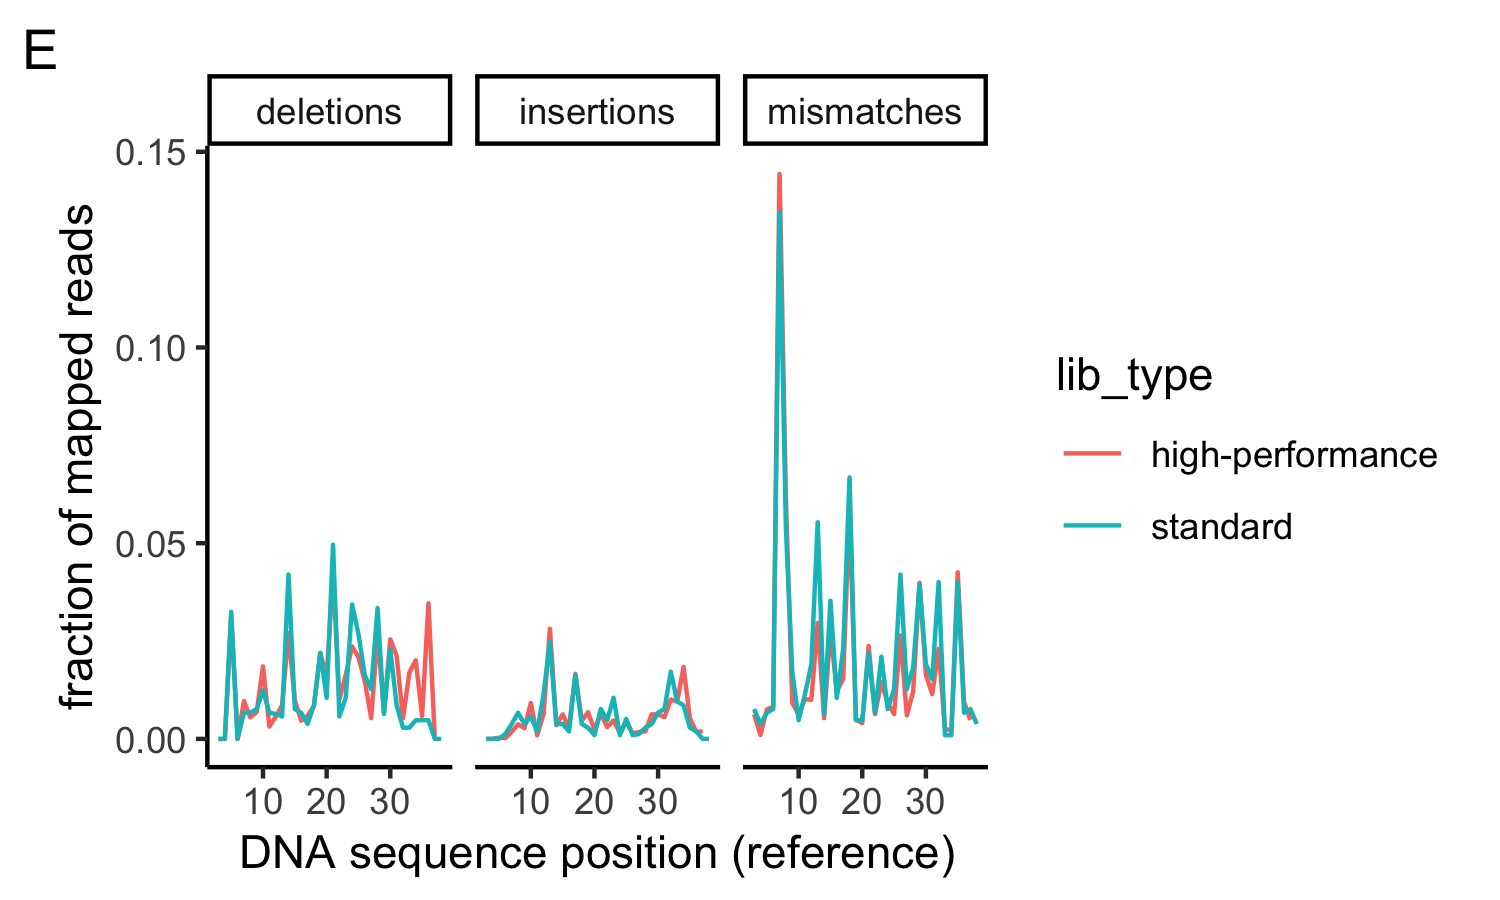

In [82]:
###
### Figure 2E
###

# function to parse cigar
parse_cigar <- function(cigar, ref_start) {
  
  # remove hard clips (H)
  cigar <- gsub("\\d+H", "", cigar)
  
  # regex to capture all CIGAR operations
  cigar_ops <- str_extract_all(cigar, "\\d+[MIDNSHP=X]")[[1]]
  
  ref_pos <- ref_start  
  insertions <- c()
  deletions <- c()
  mismatches <- c()
  
  for (op in cigar_ops) {
    # get operation and the length
    op_length <- as.numeric(str_extract(op, "\\d+"))
    op_type <- str_extract(op, "[MIDNSHP=X]")
    
    if (op_type == "=") {
      # matches
      ref_pos <- ref_pos + op_length
    } else if (op_type == "X") {
      # mismatches
      mismatches <- c(mismatches, ref_pos:(ref_pos + op_length - 1))
      ref_pos <- ref_pos + op_length
    } else if (op_type == "I") {
      # insertions
      insertions <- c(insertions, ref_pos)
    } else if (op_type == "D") {
      # deletions
      deletions <- c(deletions, ref_pos:(ref_pos + op_length - 1))
      ref_pos <- ref_pos + op_length
    }
  }
  
  return(
      list(
          insertions = insertions,
          deletions = deletions,
          mismatches = mismatches
      )
  )
}

bam_tb_parsed <- bam_tb %>%
  filter(
    NM < 3 & width > 36
  ) %>%  
  rowwise() %>%
  mutate(parsed = list(parse_cigar(cigar, start))) %>%
  unnest_wider(parsed)

mism_tb <- bam_tb_parsed %>%
  select(
    library, lib_type, seqid, insertions, deletions, mismatches
  ) %>%
  unnest()

total_reads <- mism_tb %>% 
  group_by(library, lib_type) %>% 
  distinct(seqid) %>%
  tally(name = "n_total") %>% 
  group_by(lib_type) %>% 
  summarise(
    total_mean = mean(n_total)
  )

errors_tb <- mism_tb %>% 
  pivot_longer(
    cols = c(insertions, deletions, mismatches),
    names_to = "event_type", 
    values_to = "position",
    values_drop_na = TRUE
  ) %>%
  group_by(library, lib_type, position, event_type) %>%
  summarise(
    count = n(), .groups = 'drop'
  ) %>% 
  pivot_wider(
    names_from = event_type,
    values_from = count, values_fill = 0
  ) %>%
  group_by(lib_type, position) %>% 
  summarise(
    mismatches_mean = mean(mismatches),
    deletions_mean = mean(deletions),
    insertions_mean = mean(insertions)
  ) %>%
  left_join(., total_reads) %>% 
  mutate(
    insertions_fraction = insertions_mean/total_mean,
    deletions_fraction = deletions_mean/total_mean,
    mismatches_fraction = mismatches_mean/total_mean
  )

f2e <- errors_tb %>% 
  select(
    lib_type, position, contains("fraction")
  ) %>% 
  gather(
    var, val, -position, -lib_type
  ) %>% 
  mutate(
    var = gsub("_fraction", "", var)
  ) %>% 
  ggplot(
    aes(x = position, val, color = lib_type, group = interaction(lib_type))
  ) +
  geom_line() +
  facet_grid(~var) +
  theme_classic() +
  labs(
    tag = "E",
    x = "DNA sequence position (reference)",
    y = "fraction of mapped reads"
  )

f2e
